In [1]:
# you may need to install those modules, uncomment and run if needed
#!pip install xgboost
#!pip install pandas-gbq -U

In [2]:
import pandas as pd
import pandas_gbq as gbq
import datetime

In [3]:
#importing packages
%matplotlib inline
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
plt.style.use('ggplot')

In [4]:
#Replace with your own project values
project_id = "fmolina-is"
query_project_id = "fmolina-is"
query_dataset = "cloud4healthcare"
query_table = "bcpred"

In [6]:
#Get data from Big Query
df_bcpred = gbq.read_gbq('''
SELECT * FROM `fmolina-is.cloud4healthcare.bcpred`;
''', project_id=project_id, dialect='standard', verbose=False)
df_bcpred.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  This is separate from the ipykernel package so we can avoid doing imports until
Downloading: 100%|██████████| 683/683 [00:00<00:00, 2905.93rows/s]


,SampleCodeNumber,ClumpThickness,UniformityOfCellSize,UniformityOfCellShape,MarginalAdhesion,SingleEpithelialCellSize,BareNuclei,BlandChromatin,NormalNucleoli,Mitoses,Class
0,1018099,1,1,1,1,2,10,3,1,1,2
1,1035283,1,1,1,1,1,1,3,1,1,2
2,1043999,1,1,1,1,2,3,3,1,1,2
3,1059552,1,1,1,1,2,1,3,1,1,2
4,1070935,1,1,3,1,2,1,1,1,1,2


In [7]:
#cancer vs. legit count
count = df_bcpred.Class.value_counts()
legit = count[2]
cancer = count[4]
legit_pct = (legit/(legit+cancer))*100
cancer_pct = (cancer/(legit+cancer))*100
print('   {:.3f}% legit sample, total count of {} vs {:.3f}% cancer samples , total count of {}.'.format(legit_pct,legit, cancer_pct,cancer))


   65.007% legit sample, total count of 444 vs 34.993% cancer samples , total count of 239.


Text(0.5, 1.0, 'Correlogram')

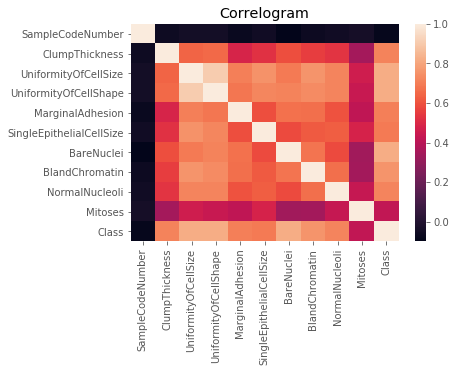

In [8]:
# Ensure there is no higly correlated feature so we can lighten the process by merging them
corr = df_bcpred.corr()
heat = sns.heatmap(data=corr)
plt.title('Correlogram')

In [9]:
# Split the dataset in Training 70%  and Testing datasets
mask = np.random.rand(len(df_bcpred)) < 0.70
train = df_bcpred[mask]
test = df_bcpred[~mask]

#Reseting Index as we randomly took transactions they came with their indexes from first dataset
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

#how many random samples from legit do we need?
trainingCancerCount = train.Class.value_counts()[4]
print('There are {} cancer samples in the train data.'.format(trainingCancerCount))

There are 173 cancer samples in the train data.


In [10]:
#4-  Dimension reduction to help visualize the dataset on a 2d space
from sklearn.manifold import TSNE
# the training dataset without the column we want to target
X = train.drop('Class', axis=1)
# the target prediction column
y = train['Class']

In [11]:
#t-SNE
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

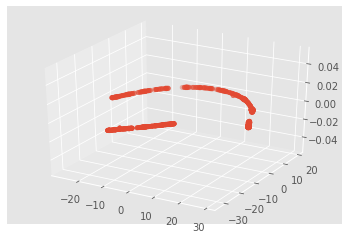

In [12]:
# t-SNE 3D visualisation of the training dataset
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*zip(*X_reduced_tsne))

plt.show()

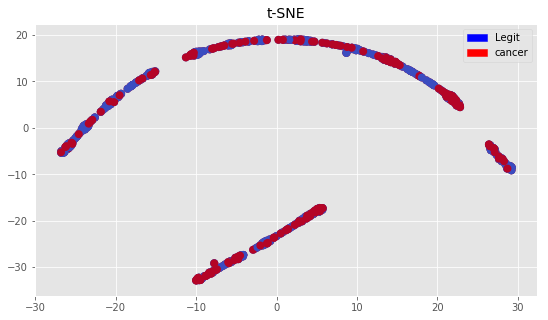

In [13]:
# t-SNE 2D visualisation of the training dataset
import matplotlib.patches as mpatches
f, ax = plt.subplots(figsize=(9,5))

legit_patch = mpatches.Patch(color='blue', label='Legit')
cancer_patch = mpatches.Patch(color='red', label='cancer')

ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 2 ), cmap='coolwarm', label='Legit', linewidths=2)
ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 4), cmap='coolwarm', label='Cancer', linewidths=2)
ax.set_title('t-SNE', fontsize=14)

ax.grid(True)
ax.legend(handles=[legit_patch, cancer_patch])

In [14]:
#prepare the datasets for fitting models
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [15]:
X_train = X_train.values
X_validation = X_test.values
y_train = y_train.values
y_validation = y_test.values

In [16]:
#Import validation functions and classification models from library
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier


In [17]:
#Finding the best model for our classification problem
# by using the cross_val_score with the roc_auc

#Ignore the warnings to have a greater visibility in console
def warn(*args, **kwargs):
    pass
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.warn = warn

#Instanciate the models and place them in an array
models = []
models.append(('sk_LR', LogisticRegression()))
models.append(('sk_LDA', LinearDiscriminantAnalysis()))
models.append(('sk_KNN', KNeighborsClassifier()))
models.append(('sk_CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('XGB', XGBClassifier()))
models.append(('RF', RandomForestClassifier()))

#instanciates placeholders for the different models
results = []
names = []

#iterates on each models to check the model using the cross_val_score function
for name, model in models:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    #msg = '%s model : {:.2f} % accuracy,  (%f)' % (name, cv_results.mean()*100, cv_results.std())
    msg = '{}: {:.2f} % accuracy,  ({:.4f} std)'.format(name, cv_results.mean()*100, cv_results.std())

    print(msg)

sk_LR: 62.71 % accuracy,  (0.1365 std)
sk_LDA: 99.03 % accuracy,  (0.0168 std)
sk_KNN: 66.23 % accuracy,  (0.0504 std)
sk_CART: 93.59 % accuracy,  (0.0289 std)
SVM: 52.22 % accuracy,  (0.0887 std)
XGB: 98.49 % accuracy,  (0.0254 std)
RF: 98.90 % accuracy,  (0.0165 std)


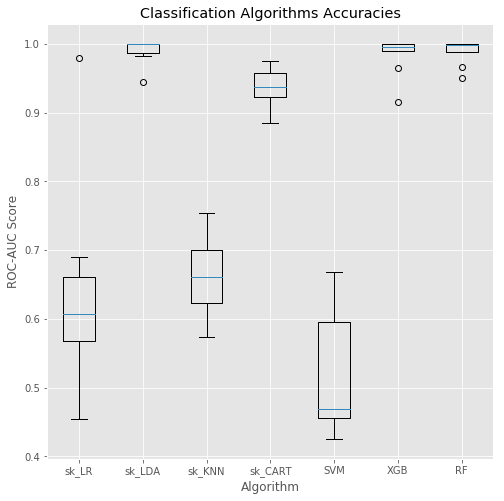

In [18]:
#Compare Algorithms
fig = plt.figure(figsize=(8,8))
plt.title('Classification Algorithms Accuracies')
plt.xlabel('Algorithm')
plt.ylabel('ROC-AUC Score')
plt.boxplot(results)
ax = fig.add_subplot(111)
ax.set_xticklabels(names)

plt.show()

In [19]:
#Working with XgBoost Classifier as it did great
XGB = XGBClassifier()

#Model training
XGB.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [20]:
# Trying prediction from the trained model
#Preparing new sample then XGB.predict( new sample data)  
TesttxnXGB = [1196295,2,2,10,2,6,2,1,1,6]

#Model prediction on new data
predict = XGB.predict(TesttxnXGB)  
print (predict[0])

#The predict result is the predicted Class 2 for legit and 4 for Cancer prediction sample
if predict[0] == 2:
    print("Legit sample, sample data : {} ".format(TesttxnXGB) )
if predict[0] == 4:
    print("cancer sample, sample data: {} ".format(TesttxnXGB))


2
Legit sample, sample data : [1196295, 2, 2, 10, 2, 6, 2, 1, 1, 6] 
